In [3]:
import numpy as np
import matplotlib.pyplot as plt
from montecarlo import MonteCarlo

# Initialization

In [4]:
# Number of rows and columns
N_i, N_j = 10, 10
# Magnetic field
epsilon = 0
# Exchange energy
J = -1
# Type of the boundary condition
# BC_type = 'PBC'
# Differentiation steps
delta_epsilon = 0.001
delta_T = 0.001
# Boltzman's constant
k_B = 1

# Computation

## Monte Carlo

In [5]:
lattice_1 = MonteCarlo(np.ones((N_i, N_j)), J=J)
Ts = np.linspace(0, 5, 50)
M_T_1 = lattice_1.magnetization_Ts(Ts, 1000, 'PBC')

/home/farid/Workspace/khu/proj/codes/montecarlo.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.random.ranf() <= np.exp(-E_flip / (self.k_B * self.T)):


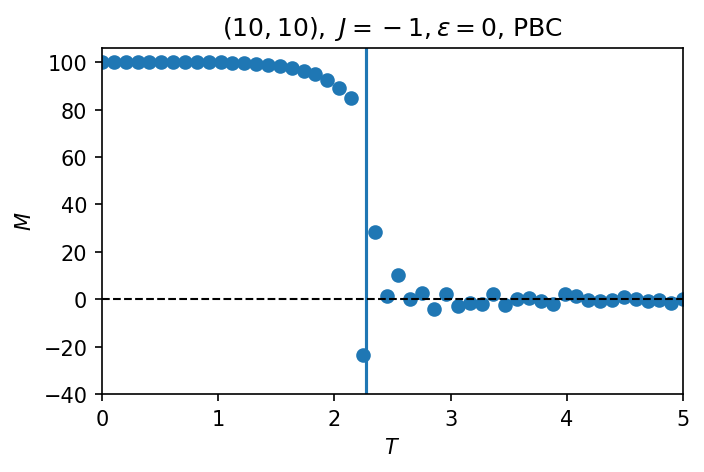

In [6]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.scatter(Ts, M_T_1)
ax.axvline(2.27)
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$M$')
ax.set_title(r'$({}, {}),\ J = {}, \epsilon = {}$, PBC'.format(
    N_i, N_j, J, epsilon))
ax.set_xlim(Ts.min(), Ts.max())
ax.set_ylim(bottom=-40)
ax.axhline(0, ls='--', c='black', lw=1)

### $M$ Distribution

In [14]:
lattice_2 = MonteCarlo(np.ones((N_i, N_j)), J=J, T=1.5)
lattice_3 = MonteCarlo(np.ones((N_i, N_j)), J=J, T=2.0)
M2_s = []
M3_s = []
for _ in range(1000):
    M2_s.append(lattice_2.magnetization_Ns(T=1.5, n=1))
    M3_s.append(lattice_3.magnetization_Ns(T=2.0, n=1))
M2_s = np.array(M2_s)
M3_s = np.array(M3_s)

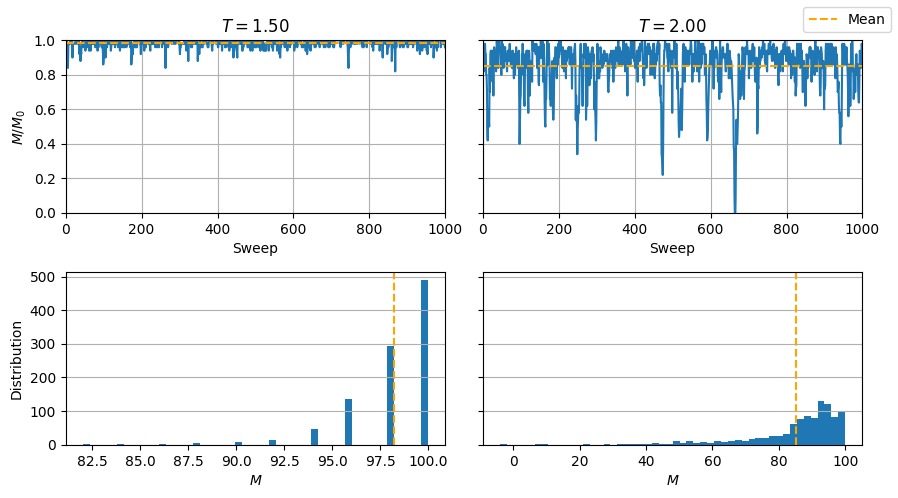

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharey='row')
axes[0, 0].plot(M2_s / lattice_2.lattice.size)
axes[0, 1].plot(M3_s / lattice_3.lattice.size)
axes[0, 0].axhline(M2_s.mean() / lattice_2.lattice.size,
                   c='orange', ls='--', label='Mean')
axes[0, 1].axhline(M3_s.mean() / lattice_3.lattice.size, c='orange', ls='--')
axes[0, 0].set_title(r'$T = {:.2f}$'.format(lattice_2.T))
axes[0, 1].set_title(r'$T = {:.2f}$'.format(lattice_3.T))
axes[0, 0].set_ylabel(r'$M / M_0$')
for ax in axes[0]:
    ax.set_xlabel('Sweep')
    ax.set_xlim(0, len(M2_s))
    ax.set_ylim(0, 1)
    ax.grid()
axes[1, 0].hist(M2_s, bins=50)
axes[1, 1].hist(M3_s, bins=50)
axes[1, 0].axvline(M2_s.mean(), c='orange', ls='--')
axes[1, 1].axvline(M3_s.mean(), c='orange', ls='--')
axes[1, 0].set_xlabel(r'$M$')
axes[1, 1].set_xlabel(r'$M$')
axes[1, 0].set_ylabel(r'Distribution')
for ax in axes[1]:
    ax.grid(axis='y')
fig.legend()
fig.tight_layout()

### OBC vs PBC

In [7]:
lattice_1 = MonteCarlo(np.ones((N_i, N_j)), J=J)
lattice_2 = MonteCarlo(np.ones((N_i, N_j)), J=J)
Ts = np.linspace(0, 3, 50)
M_T_1 = lattice_1.magnetization_Ts(Ts, 1000, 'OBC')
M_T_2 = lattice_2.magnetization_Ts(Ts, 1000, 'PBC')

/home/farid/Workspace/khu/proj/codes/montecarlo.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.random.ranf() <= np.exp(-E_flip / (self.k_B * self.T)):
/home/farid/Workspace/khu/proj/codes/montecarlo.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.random.ranf() <= np.exp(-E_flip / (self.k_B * self.T)):


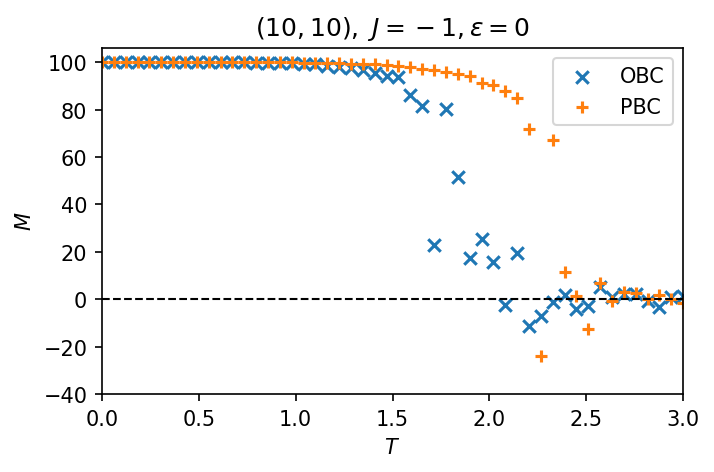

In [8]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.scatter(Ts, M_T_1, label='OBC', marker='x')
ax.scatter(Ts, M_T_2, label='PBC', marker='+')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$M$')
ax.set_title(r'$({}, {}),\ J = {}, \epsilon = {}$'.format(
    N_i, N_j, J, epsilon))
ax.set_xlim(Ts.min(), Ts.max())
ax.set_ylim(bottom=-40)
ax.axhline(0, ls='--', c='black', lw=1)
ax.legend()

### Variable $J$

In [9]:
def custom_E_flip(
    self,
    coord: tuple[int, int],
    site_spin: (int | float),
    neighbor_spin: np.ndarray
) -> (int | float):
    J_1, J_2, J_3 = -0.8, -1, -1
    if coord[1] % 2 == 0:
        self.J = np.array([J_2, J_1, J_3, J_3])
    else:
        self.J = np.array([J_1, J_2, J_3, J_3])
    return -2 * (site_spin * (self.J * neighbor_spin).sum() +
                 self.epsilon * site_spin)


MonteCarlo.E_flip = custom_E_flip
lattice_1 = MonteCarlo(np.ones((N_i, N_j)))
lattice_2 = MonteCarlo(np.ones((N_i, N_j)))
Ts = np.linspace(0, 3, 50)
M_T_1 = lattice_1.magnetization_Ts(Ts, 2000, 'OBC')
M_T_2 = lattice_2.magnetization_Ts(Ts, 2000, 'PBC')

/home/farid/Workspace/khu/proj/codes/montecarlo.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.random.ranf() <= np.exp(-E_flip / (self.k_B * self.T)):
/home/farid/Workspace/khu/proj/codes/montecarlo.py:138: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.random.ranf() <= np.exp(-E_flip / (self.k_B * self.T)):


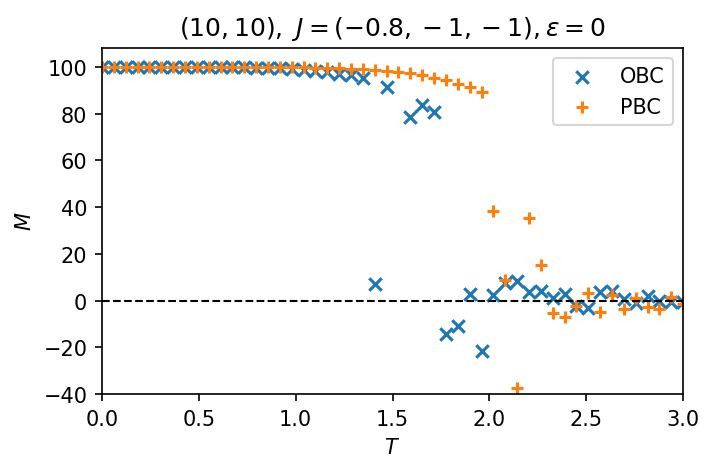

In [10]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.scatter(Ts, M_T_1, label='OBC', marker='x')
ax.scatter(Ts, M_T_2, label='PBC', marker='+')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$M$')
ax.set_title(r'$({}, {}),\ J = (-0.8, -1, -1), \epsilon = {}$'.format(
    N_i, N_j, epsilon))
ax.set_xlim(Ts.min(), Ts.max())
ax.set_ylim(bottom=-40)
ax.axhline(0, ls='--', c='black', lw=1)
ax.legend()